In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from python_speech_features import mfcc ,logfbank
from scipy.io import wavfile
import csv
from tqdm import tqdm
import tensorflow as tf
import keras
from keras.utils import to_categorical 
from keras.layers import *
from keras.models import  Sequential
from sklearn.utils.class_weight import compute_class_weight
import pickle
from keras.callbacks import ModelCheckpoint


In [3]:
df=pd.read_csv('audio_without_pitch.csv')
df.set_index('filename',inplace=True)
df

,label
filename,
neg-0421-083-cough-m-53-0.wav,healthy
neg-0421-083-cough-m-53-1.wav,healthy
neg-0421-083-cough-m-53-10.wav,healthy
neg-0421-083-cough-m-53-11.wav,healthy
neg-0421-083-cough-m-53-12.wav,healthy
...,...
pos-0422-096-cough-m-31-1.wav,covid
pos-0422-096-cough-m-31-2.wav,covid
pos-0422-096-cough-m-31-6.wav,covid


In [4]:
for f in df.index:
    rate,signal=wavfile.read('clean/'+ f )
    df.at[f,'length']=signal.shape[0]/rate
classes=list(np.unique(df.label))
class_dist=df.groupby(['label'])['length'].mean()
class_dist

label
covid      2.20033
healthy    1.88508
Name: length, dtype: float64

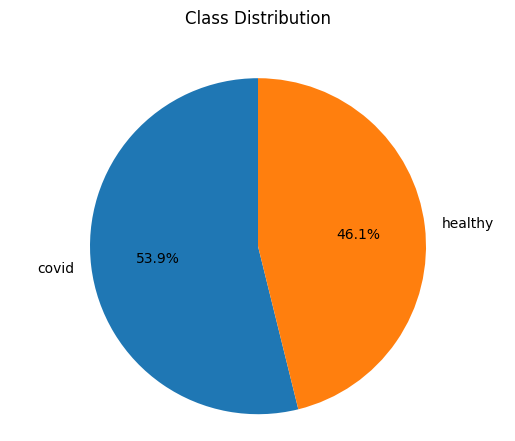

In [5]:
fig ,ax=plt.subplots()
ax.set_title("Class Distribution",y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',
       shadow=False,startangle=90)
ax.axis('equal')
plt.show()

In [6]:
2*int(df['length'].sum()/.1)

5510

In [7]:
df.head(2)

,label,length
filename,,
neg-0421-083-cough-m-53-0.wav,healthy,0.398562
neg-0421-083-cough-m-53-1.wav,healthy,0.465438


In [65]:
def built_rand_feat():
    X=[]
    y=[]
    _min,_max=float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class=np.random.choice(class_dist.index,p=prob_dist)
        file=np.random.choice(df[df['label']==rand_class].index)
        rate,wav=wavfile.read('clean/' + file )
        # label=rand_class
        label=df.at[file,'label']
        rand_index=np.random.randint(0,wav.shape[0]-config.step)
        sample=wav[rand_index:rand_index+config.step]
        X_sample=mfcc(sample,rate,numcep=config.nfeat,
                      nfilt=config.nfilt,nfft=config.nfft)
        _min=min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        X.append(X_sample if config.mode=='conv' else x_sample.T)
        y.append(classes.index(label))
    X,y=np.array(X),np.array(y)
    X=(X - _min)/(_max-_min)  # to normalise the data 
    if config.mode=='conv':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode=="time":
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
    y=to_categorical(y,num_classes=10)
    return X,y

    
        
    
class Config:
    def __init__(self,mode='conv',nfilt=26,nfeat=13,nfft=512,rate=16000):
        self.mode=mode
        self.rate=rate
        self.nfft=nfft
        self.nfeat=nfeat
        self.nfilt=nfilt
        self.step=int(rate/10)
    



In [66]:
        
n_samples=2* int(df['length'].sum()/.1)
prob_dist= class_dist/class_dist.sum()
choices=np.random.choice(class_dist.index,p=prob_dist)
# print(type(str(choices)))
file=np.random.choice(df[df['label']==choices].index)
file
'clean/'  + os.path.basename(file)
type(df.at[file,'label'])

<class 'str'>


str

In [74]:
def get_conv_model():
    model=Sequential()
    model.add(Conv2D( 16 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same',input_shape=input_shape))
    model.add(Conv2D( 32 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(Conv2D( 64 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(Conv2D( 128 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile( loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

def get_recurrent_model():
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile( loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model


    

In [67]:
config=Config(mode='conv')
if config.mode=='conv':
    X,y=built_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=X.shape[1:]
    model=get_conv_model()


elif config.mode=="time":
    X,y=built_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=X.shape[1:]
    model=get_recurrent_model()
class_weight=compute_class_weight('balanced',
                                  np.unique(y_flat),y_flat)



100%|██████████| 25706/25706 [00:48<00:00, 532.70it/s]


In [ ]:
model.fit(X,y,epochs=10,batch_size=32,
          shuffle=True,class_weight=class_weight)

In [71]:
X.shape[1:]

(9, 13, 1)

In [70]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [95]:
from keras.models import load_model
from scipy.io import wavfile
from python_speech_features import mfcc ,logfbank
from sklearn.metrics import accuracy_score
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [123]:
for i in y_true:
    arr=np.zeros(10)
    for x in range(10):
        if i == x:
            arr[i]+=1
np.argmax(arr)



    pass
len(y_true)
arr[1]=9


1

In [131]:
len(os.listdir(audio_dir))

300

In [167]:

def make_prediction(audio_dir='clean/'):

    y_true=[]
    y_pred=[]
    fn_prob={}
    a=0
    print('Extracting features from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav=wavfile.read(os.path.join(audio_dir,fn))
        label=fn2class[fn]
        c=classes.index(label)
        y_prob=[]
        for i in range(0,wav.shape[0]-config.step,config.step):
            sample=wav[i : i+ config.step]
            x=mfcc(sample,rate,numcep=config.nfeat,
                    nfilt=config.nfilt,nfft=config.nfft)
            x = (x-config.min)/(config.max-config.min)

            if config.mode=='conv':
                x=x.reshape(1,x.shape[0],x.shape[1],1)
            elif config.mode=='time':
                x=x.reshape(1,x.shape[0],x.shape[1])
                # x=np.expand_dims(x,axis=0)
            y_hat=model.predict(x)
            y_prob.append(y_hat)
            # y_pred.append(np.argmax(y_hat))
        y_true.append(c)

        fn_prob[fn]=np.mean(y_prob,axis=0).flatten()
        y_pred.append(np.argmax(fn_prob[fn]))

        # a+=1
        # if a==50:
        #     break
        
    return y_true,y_pred,fn_prob 

In [157]:
df=pd.read_csv('instrument.csv')
classes=list(np.unique(df.label))
# x=(zip((df.filename),df.label))
fn2class={}
for i,row in df.iterrows():
    fn2class[os.path.basename(row[0])]=row[1]
fn2class

{'0356dec7.wav': 'Acoustic_guitar',
 '0eeaebcb.wav': 'Acoustic_guitar',
 '10da16fb.wav': 'Acoustic_guitar',
 '160c92d7.wav': 'Acoustic_guitar',
 '16c9a838.wav': 'Acoustic_guitar',
 '17f82c05.wav': 'Acoustic_guitar',
 '2016d256.wav': 'Acoustic_guitar',
 '236cbab1.wav': 'Acoustic_guitar',
 '32dee61b.wav': 'Acoustic_guitar',
 '34747922.wav': 'Acoustic_guitar',
 '35039ae1.wav': 'Acoustic_guitar',
 '367ad7b1.wav': 'Acoustic_guitar',
 '38216fad.wav': 'Acoustic_guitar',
 '44fb3eeb.wav': 'Acoustic_guitar',
 '55822aae.wav': 'Acoustic_guitar',
 '673defaf.wav': 'Acoustic_guitar',
 '70ca9c77.wav': 'Acoustic_guitar',
 '7506dcc4.wav': 'Acoustic_guitar',
 '8da75280.wav': 'Acoustic_guitar',
 '9923ddf8.wav': 'Acoustic_guitar',
 'a25423a8.wav': 'Acoustic_guitar',
 'a6728901.wav': 'Acoustic_guitar',
 'b2261238.wav': 'Acoustic_guitar',
 'b88322f6.wav': 'Acoustic_guitar',
 'bb1f5874.wav': 'Acoustic_guitar',
 'c7846d27.wav': 'Acoustic_guitar',
 'd8a257e5.wav': 'Acoustic_guitar',
 'e92bf0fa.wav': 'Acoustic_g

In [168]:
# df2=df.copy()
df2

,filename,label,Acoustic_guitar,Bass_drum,Cello,Clarinet,Double_bass,Flute,Hi_hat,Saxophone,Snare_drum,Violin_or_fiddle,y_pred_class
0,wavfiles/Acoustic_guitar/0356dec7.wav,Acoustic_guitar,8.899302e-01,5.556477e-04,1.618010e-02,0.000300,1.352708e-03,4.725361e-03,3.124779e-04,5.042328e-02,7.288141e-03,0.028932,Acoustic_guitar
1,wavfiles/Acoustic_guitar/0eeaebcb.wav,Acoustic_guitar,9.849235e-01,1.749233e-07,5.828631e-04,0.000024,1.783660e-03,1.246008e-02,5.072363e-08,2.152654e-04,3.659999e-07,0.000010,Acoustic_guitar
2,wavfiles/Acoustic_guitar/10da16fb.wav,Acoustic_guitar,9.965799e-01,3.957040e-09,2.865327e-04,0.000717,1.130232e-05,6.363651e-04,2.413874e-06,7.372082e-04,1.468713e-05,0.001014,Acoustic_guitar
3,wavfiles/Acoustic_guitar/160c92d7.wav,Acoustic_guitar,9.922186e-01,2.348783e-10,2.000818e-04,0.000012,1.661550e-05,1.476320e-03,5.688047e-08,9.604976e-06,1.035927e-06,0.006066,Acoustic_guitar
4,wavfiles/Acoustic_guitar/16c9a838.wav,Acoustic_guitar,9.526749e-01,5.661145e-09,5.468120e-03,0.032382,7.257993e-06,1.900795e-03,1.198067e-10,3.421866e-04,4.577920e-07,0.007225,Acoustic_guitar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,wavfiles/Violin_or_fiddle/d6144e01.wav,Violin_or_fiddle,1.155699e-10,9.222989e-18,3.182252e-11,0.000010,8.605647e-12,8.361421e-12,2.915936e-17,1.132541e-09,9.005035e-14,0.999990,Violin_or_fiddle
296,wavfiles/Violin_or_fiddle/d84c8c43.wav,Violin_or_fiddle,1.650122e-03,2.399089e-03,2.256621e-02,0.004926,1.319285e-02,5.866803e-04,1.510119e-05,3.340733e-04,6.845315e-04,0.953645,Violin_or_fiddle
297,wavfiles/Violin_or_fiddle/d914225a.wav,Violin_or_fiddle,1.639364e-03,1.295783e-06,1.544574e-02,0.014150,1.302915e-02,3.417498e-04,5.456144e-07,7.836477e-04,7.680559e-04,0.953841,Violin_or_fiddle
298,wavfiles/Violin_or_fiddle/e3f479f3.wav,Violin_or_fiddle,8.222368e-04,1.349039e-07,4.108805e-02,0.000761,3.449939e-08,2.155112e-03,2.139528e-03,5.314303e-03,3.393009e-07,0.947720,Violin_or_fiddle


In [1]:
# p_path=os.path.join('pickles','conv.p')
# with open(p_path,'rb') as handle:
#     config = pickle.load(handle)
# model=load_model(config.model_path)
# y_true,y_pred,fn_prob=make_prediction('clean/')
# acc_score=accuracy_score(y_true=y_true,y_pred=y_pred)
# # y_probs=[]
# # for i,row in df2.iterrows():
# #     y_prob=fn_prob[os.path.basename(row.filename)]
# #     y_probs.append(y_prob)
# #     for c,p in zip(classes,y_prob):
# #         df2.at[i,c]=p

# # y_pred_class=[classes[np.argmax(y)] for y in y_probs]
# # df2['y_pred_class']=y_pred_class
# # df2.to_csv('predictions.csv',index=False)

In [172]:
accuracy_score(y_true=y_true,y_pred=y_pred)

1.0

In [104]:
from sklearn.metrics import roc_curve, auc,roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
classes


['Acoustic_guitar',
 'Bass_drum',
 'Cello',
 'Clarinet',
 'Double_bass',
 'Flute',
 'Hi_hat',
 'Saxophone',
 'Snare_drum',
 'Violin_or_fiddle']

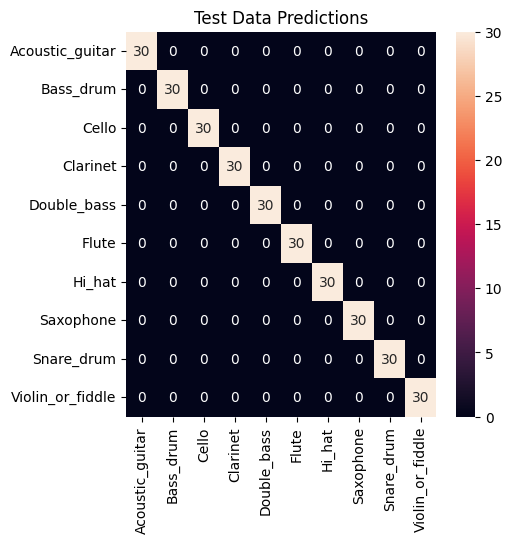

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        30
           9       1.00      1.00      1.00        30

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [173]:
def plot_actual_vs_predicted(y_true,y_pred,title,grafik='yüzde',cmp='cividis'):
    cm = confusion_matrix(y_true,y_pred)
    cm=cm.astype(np.double)
    #cm=cm/np.sum(cm)

    plt.figure(figsize=(5,5))
    if (grafik=='yüzde'):
      cm=(np.round(cm / cm.sum(axis=1),4))#*100
      sns.heatmap(cm,annot=True,fmt='.2%',xticklabels=classes,yticklabels=classes) #fmt='g',
    else:
      sns.heatmap(cm,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)
    plt.title(title)
    plt.show()
    print("Classification Report")
    print(classification_report(y_true,y_pred))
plot_actual_vs_predicted(y_true,y_pred,"Test Data Predictions",'normal')

In [140]:
accuracy_score(y_true=y_true,y_pred=y_pred)

0.26666666666666666

In [143]:
n_scores = np.array([
        [93, 72, 75, 51, 83],
        [94, 53, 57, 56, 48],
        [91, 77, 82, 91, 76],
        [97, 56, 82, 33, 74],
        [94, 76, 72, 63, 76],
        [97, 56, 49, 53, 42],
        [91, 93, 90, 88, 96],
       [91, 56, 77, 74, 74],
 ])

In [148]:
np.mean(n_scores,axis=0).flatten()

array([93.5  , 67.375, 73.   , 63.625, 71.125])

In [2]:




import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from python_speech_features import mfcc ,logfbank
from scipy.io import wavfile
import csv
from tqdm import tqdm
import tensorflow as tf
import keras
from keras.utils import to_categorical 
from keras.layers import *
from keras.models import  Sequential
from sklearn.utils.class_weight import compute_class_weight
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config
from sklearn.model_selection import train_test_split
from keras.callbacks import History


def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path,'rb') as f:
            tmp=pickle.load(f)
            return tmp
    else:
        return None

def built_rand_feat():
    tmp=check_data()
    if tmp:
        return tmp.data[0],tmp.data[1]
    X=[]
    y=[]
    _min,_max=float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class=np.random.choice(class_dist.index,p=prob_dist)
        file=np.random.choice(df[df['label']==rand_class].index)
        rate,wav=wavfile.read('clean/' + file)
        # label=rand_class
        label=df.at[file,'label']
        rand_index=np.random.randint(0,wav.shape[0]-config.step)
        sample=wav[rand_index:rand_index+config.step]
        X_sample=mfcc(sample,rate,numcep=config.nfeat,
                      nfilt=config.nfilt,nfft=config.nfft)
        _min=min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        # X.append(X_sample if config.mode=='conv' else x_sample.T)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min=_min
    config.max=_max
    X,y=np.array(X),np.array(y)
    X=(X - _min)/(_max-_min)  # to normalise the data 

    if config.mode=='conv2':
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode=="time":
        X=X.reshape(X.shape[0],X.shape[1],X.shape[2])

    y=to_categorical(y,num_classes=2)

    config.data=(X,y)
    with open(config.p_path,'wb') as f:
        pickle.dump(config,f,protocol=2)

    return X,y



def get_conv_model():
    model=Sequential()
    model.add(Conv2D( 16 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same',input_shape=input_shape))
    model.add(Conv2D( 32 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(Conv2D( 64 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(Conv2D( 128 ,kernel_size=(3,3),activation="relu",strides=(1,1),
                     padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.summary()
    model.compile( loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

def get_recurrent_model():
    model=Sequential()
    model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.summary()
    model.compile( loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model



df=pd.read_csv('audio_without_pitch.csv')

y=df['label']
x=df.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
train=pd.concat( [x_train,y_train],axis=1,)
train.reset_index(drop=True,inplace=True)

df=train


df.set_index('filename',inplace=True)

for f in df.index:
    rate,signal=wavfile.read('clean/'+f)
    df.at[f,'length']=signal.shape[0]/rate
classes=list(np.unique(df.label))
class_dist=df.groupby(['label'])['length'].mean()

n_samples=4* int(df['length'].sum()/.1)
prob_dist= class_dist/class_dist.sum()
choices=np.random.choice(class_dist.index,p=prob_dist)

# fig ,ax=plt.subplots()
# ax.set_title("Class Distribution",y=1.08)
# ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',
#        shadow=False,startangle=90)
# ax.axis('equal')
# plt.show()




config=Config(mode='conv2')

if config.mode=='conv2':
    X,y=built_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=X.shape[1:]
    model=get_conv_model()


elif config.mode=="time":
    X,y=built_rand_feat()
    y_flat=np.argmax(y,axis=1)
    input_shape=X.shape[1:]
    model=get_recurrent_model()

# class_weight=compute_class_weight('balanced',
#                                   classes=np.unique(y_flat),y=y_flat)
# class_weight=class_weight,
checkpoint=ModelCheckpoint(config.model_path,monitor='val_acc',verbose=1,mode='max',
                            save_best_only=True,save_weights_only=False,period=1)



history=model.fit(X,y,epochs=20,batch_size=32,
          shuffle=True,validation_split=0.1,callbacks=[checkpoint])
model.save(config.model_path)



Loading existing data for conv2 model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 13, 16)         160       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 13, 32)         4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 13, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 6, 128)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 6, 128)         0         
                  

INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 10s 36ms/step - loss: 0.5890 - acc: 0.6698 - val_loss: 0.4382 - val_acc: 0.7762
Epoch 2/20
231/232 [============================>.] - ETA: 0s - loss: 0.3902 - acc: 0.8159
Epoch 2: val_acc improved from 0.77616 to 0.87348, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 35ms/step - loss: 0.3902 - acc: 0.8159 - val_loss: 0.2975 - val_acc: 0.8735
Epoch 3/20
231/232 [============================>.] - ETA: 0s - loss: 0.2861 - acc: 0.8785
Epoch 3: val_acc did not improve from 0.87348
232/232 [==============================] - 7s 31ms/step - loss: 0.2861 - acc: 0.8785 - val_loss: 0.2787 - val_acc: 0.8710
Epoch 4/20
231/232 [============================>.] - ETA: 0s - loss: 0.2197 - acc: 0.9117
Epoch 4: val_acc improved from 0.87348 to 0.91971, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.2196 - acc: 0.9117 - val_loss: 0.2103 - val_acc: 0.9197
Epoch 5/20
231/232 [============================>.] - ETA: 0s - loss: 0.1752 - acc: 0.9333
Epoch 5: val_acc improved from 0.91971 to 0.93066, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.1751 - acc: 0.9334 - val_loss: 0.1833 - val_acc: 0.9307
Epoch 6/20
231/232 [============================>.] - ETA: 0s - loss: 0.1499 - acc: 0.9463
Epoch 6: val_acc improved from 0.93066 to 0.93917, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.1498 - acc: 0.9463 - val_loss: 0.1704 - val_acc: 0.9392
Epoch 7/20
230/232 [============================>.] - ETA: 0s - loss: 0.1320 - acc: 0.9497
Epoch 7: val_acc improved from 0.93917 to 0.95134, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.1320 - acc: 0.9497 - val_loss: 0.1395 - val_acc: 0.9513
Epoch 8/20
230/232 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9614
Epoch 8: val_acc improved from 0.95134 to 0.96594, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.1077 - acc: 0.9612 - val_loss: 0.1125 - val_acc: 0.9659
Epoch 9/20
230/232 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9660
Epoch 9: val_acc did not improve from 0.96594
232/232 [==============================] - 7s 30ms/step - loss: 0.1016 - acc: 0.9659 - val_loss: 0.1235 - val_acc: 0.9647
Epoch 10/20
231/232 [============================>.] - ETA: 0s - loss: 0.0780 - acc: 0.9727
Epoch 10: val_acc improved from 0.96594 to 0.97080, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 35ms/step - loss: 0.0779 - acc: 0.9727 - val_loss: 0.1132 - val_acc: 0.9708
Epoch 11/20
231/232 [============================>.] - ETA: 0s - loss: 0.0811 - acc: 0.9728
Epoch 11: val_acc did not improve from 0.97080
232/232 [==============================] - 6s 27ms/step - loss: 0.0811 - acc: 0.9728 - val_loss: 0.1146 - val_acc: 0.9696
Epoch 12/20
230/232 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9776
Epoch 12: val_acc improved from 0.97080 to 0.97324, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.0667 - acc: 0.9777 - val_loss: 0.0992 - val_acc: 0.9732
Epoch 13/20
231/232 [============================>.] - ETA: 0s - loss: 0.0598 - acc: 0.9788
Epoch 13: val_acc did not improve from 0.97324
232/232 [==============================] - 6s 28ms/step - loss: 0.0598 - acc: 0.9788 - val_loss: 0.1063 - val_acc: 0.9696
Epoch 14/20
231/232 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9785
Epoch 14: val_acc did not improve from 0.97324
232/232 [==============================] - 6s 28ms/step - loss: 0.0605 - acc: 0.9785 - val_loss: 0.1397 - val_acc: 0.9720
Epoch 15/20
230/232 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9819
Epoch 15: val_acc improved from 0.97324 to 0.97689, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 8s 33ms/step - loss: 0.0512 - acc: 0.9820 - val_loss: 0.1332 - val_acc: 0.9769
Epoch 16/20
230/232 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9837
Epoch 16: val_acc improved from 0.97689 to 0.98054, saving model to models\conv2.model
INFO:tensorflow:Assets written to: models\conv2.model\assets


INFO:tensorflow:Assets written to: models\conv2.model\assets


232/232 [==============================] - 7s 32ms/step - loss: 0.0467 - acc: 0.9835 - val_loss: 0.0995 - val_acc: 0.9805
Epoch 17/20
231/232 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9873
Epoch 17: val_acc did not improve from 0.98054
232/232 [==============================] - 7s 28ms/step - loss: 0.0383 - acc: 0.9873 - val_loss: 0.1173 - val_acc: 0.9781
Epoch 18/20
231/232 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9831
Epoch 18: val_acc did not improve from 0.98054
232/232 [==============================] - 7s 29ms/step - loss: 0.0467 - acc: 0.9831 - val_loss: 0.0978 - val_acc: 0.9805
Epoch 19/20
231/232 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9832
Epoch 19: val_acc did not improve from 0.98054
232/232 [==============================] - 6s 28ms/step - loss: 0.0481 - acc: 0.9832 - val_loss: 0.1256 - val_acc: 0.9793
Epoch 20/20
231/232 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9867
Epo

INFO:tensorflow:Assets written to: models\conv2.model\assets


In [4]:
history.history??

Type:        dict
String form: {'loss': [0.625825047492981, 0.4125039577484131, 0.2878332734107971, 0.22186149656772614, 0.16769742965698242, 0.14133617281913757, 0.12106539309024811, 0.09848316013813019, 0.07666505873203278, 0.0765685886144638, 0.05899969860911369, 0.04841036722064018, 0.048151545226573944, 0.046616826206445694, 0.04536428675055504, 0.035823699086904526, 0.033931322395801544, 0.04329978674650192, 0.02551237680017948, 0.03187805041670799], 'acc': [0.62016761302948, 0.8053528070449829, 0.8825358152389526, 0.9118680953979492, 0.9359286427497864, 0.9455258250236511, 0.956204354763031, 0.9637739658355713, 0.9733712077140808, 0.9743173718452454, 0.9797242283821106, 0.9829683899879456, 0.9829683899879456, 0.9833738803863525, 0.9848607778549194, 0.9882400631904602, 0.9885104298591614, 0.9845904111862183, 0.991213858127594, 0.9893214106559753], 'val_loss': [0.5059665441513062, 0.3231266140937805, 0.27244383096694946, 0.18968245387077332, 0.19605912268161774, 0.1772835105657577

In [12]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

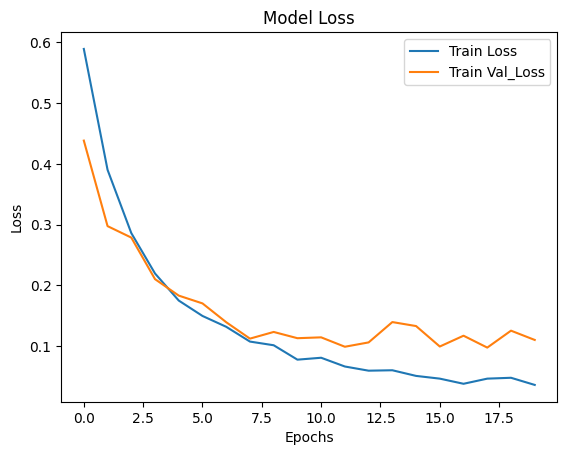

In [3]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train Loss','Train Val_Loss'],loc='upper right')
plt.show()